# Custom Datasets

In [3]:
import torch
import torchvision
from torchvision import datasets
from torchvision.transforms import v2 as transforms

In [5]:
print("PyTorch version:", torch.__version__)
print("torchvision version:", torchvision.__version__)

PyTorch version: 2.5.1+cu124
torchvision version: 0.20.1+cu124


## Dataset to Import

In [8]:
from helper_functions import download_data

data_path = download_data(
    source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
    destination="pizza_steak_sushi")

[INFO] Did not find data\pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


### Investigate Data

In [9]:
data_path

WindowsPath('data/pizza_steak_sushi')

<pre>
pizza_steak_sushi
    ┣━test
        ┣━pizza
        ┣━steak
        ┗━sushi
    ┗━train
        ┣━pizza
        ┣━steak
        ┗━sushi
</pre>

In [10]:
import os

for dirpath, dirnames, filenames in os.walk(data_path):
    print(f"In path {dirpath}, found {len(dirnames)} directories, and {len(filenames)} files.")

In path data\pizza_steak_sushi, found 2 directories, and 0 files.
In path data\pizza_steak_sushi\test, found 3 directories, and 0 files.
In path data\pizza_steak_sushi\test\pizza, found 0 directories, and 25 files.
In path data\pizza_steak_sushi\test\steak, found 0 directories, and 19 files.
In path data\pizza_steak_sushi\test\sushi, found 0 directories, and 31 files.
In path data\pizza_steak_sushi\train, found 3 directories, and 0 files.
In path data\pizza_steak_sushi\train\pizza, found 0 directories, and 78 files.
In path data\pizza_steak_sushi\train\steak, found 0 directories, and 75 files.
In path data\pizza_steak_sushi\train\sushi, found 0 directories, and 72 files.


(-0.5, 511.5, 511.5, -0.5)

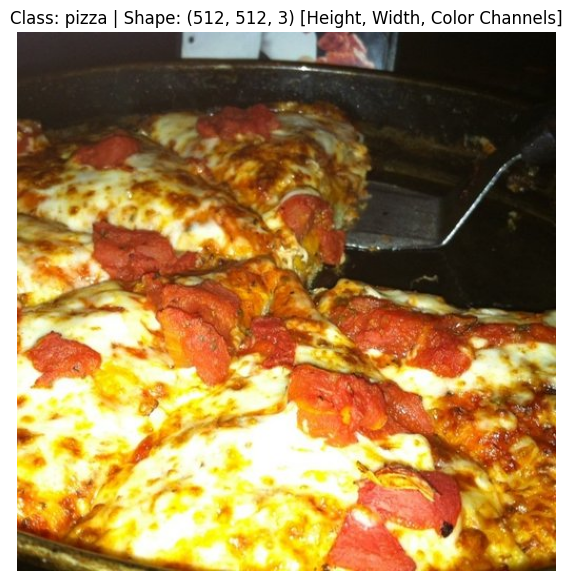

In [32]:
import random
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# random.seed(7)

# glob() takes a pattern as parameter
# *.jpg     -> files with jpg extension
# */*.jpg   -> files with jpg extension in sub folders
# */*/*.jpg -> files with jpg extension in sub folders within second degree sub-folders
# Essentially "get every .jpg under data/pizza_steak_sushi/"
image_paths = list(data_path.glob("*/*/*.jpg"))

# Randomly select one item from path list and get it's folder name too
random_image_path = random.choice(image_paths)
random_image_class = random_image_path.parent.stem

# Open jpg file as PIL Image
image = Image.open(random_image_path)

# Convert PIL image to numpy array
np_image = np.asarray(image)

# Plot numpy array with matplotlib
plt.figure(figsize=(7, 7))
plt.title(f"Class: {random_image_class} | Shape: {np_image.shape} [Height, Width, Color Channels]")
plt.imshow(np_image)
plt.axis(False)

### Importing to PyTorch

In [37]:
data_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToImage(), 
    transforms.ToDtype(dtype=torch.float32, scale=True),
])

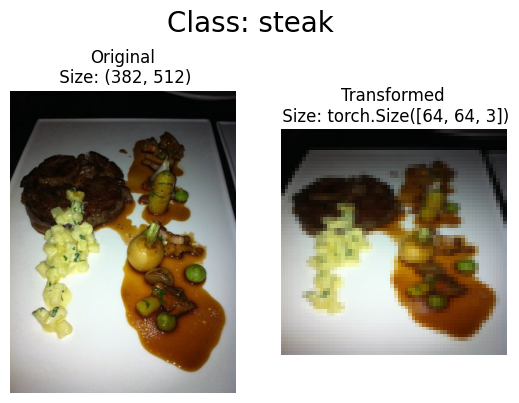

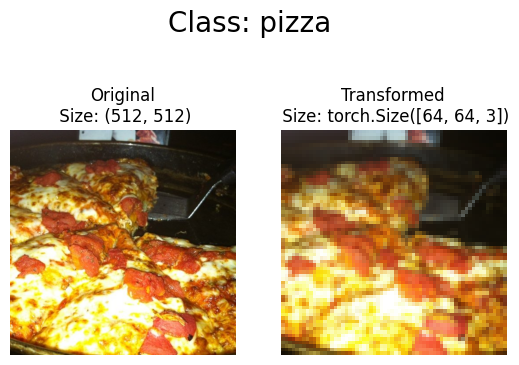

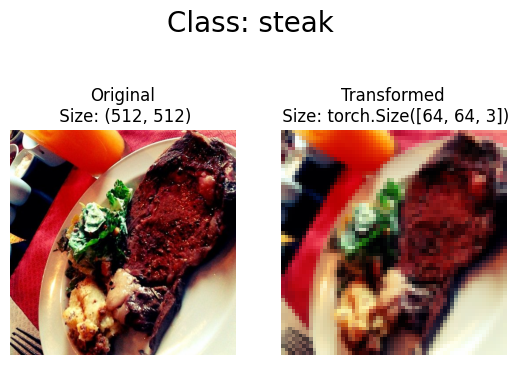

In [44]:
def plot_transformed(data_path:list, transform, num_samples=3, seed=None):
    """
    Plots number of images from image paths before and after transformation.
    """
    if seed:
        random.seed(seed)

    random_image_paths = random.sample(population=image_paths, k=num_samples)

    for image_path in random_image_paths:
        with Image.open(image_path) as i:
            fig, ax = plt.subplots(1, 2)

            # Set Original images as left column
            ax[0].set_title(f"Original\n Size: {i.size}")
            ax[0].imshow(i)
            ax[0].axis(False)

            # transform the data and arrange color channel to last
            transformed = transform(i).permute(1, 2, 0)

            # Set transformed images as right column and show like 
            # [original image] -> [transformed image]
            ax[1].set_title(f"Transformed\n Size: {transformed.shape}")
            ax[1].imshow(transformed)
            ax[1].axis(False)

            # Set figure related options
            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=20)


plot_transformed(data_path, transform=data_transform, seed=7)

In [45]:
train_dir = data_path / "train"
test_dir = data_path / "test"

train_dataset = datasets.ImageFolder(root=train_dir,
                                     transform=data_transform)

test_dataset = datasets.ImageFolder(root=test_dir,
                                     transform=data_transform)

train_dataset, test_dataset

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data\pizza_steak_sushi\train
     StandardTransform
 Transform: Compose(
                  Resize(size=[64, 64], interpolation=InterpolationMode.BILINEAR, antialias=True)
                  ToImage()
                  ToDtype(scale=True)
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data\pizza_steak_sushi\test
     StandardTransform
 Transform: Compose(
                  Resize(size=[64, 64], interpolation=InterpolationMode.BILINEAR, antialias=True)
                  ToImage()
                  ToDtype(scale=True)
            ))

In [53]:
len(train_dataset), len(test_dataset)

(225, 75)

In [47]:
class_names = train_dataset.classes
class_names

['pizza', 'steak', 'sushi']

In [48]:
class_dict = train_dataset.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [54]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(dataset=train_dataset, 
                              batch_size=32,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_dataset,
                             batch_size=32,
                             shuffle=False)


## Device Agnostic Code

In [55]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Create Model

In [123]:
import torch.nn as nn

class TinyVGG(nn.Module):
    def __init__(self,
                 in_channels, 
                 out_features, 
                 hidden_units=10):
        super().__init__()

        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=hidden_units, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )

        self.linear = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=13*13*hidden_units, out_features=out_features)
        )

    def forward(self, x):
        return self.linear(self.conv_block_2(self.conv_block_1(x)))
    
torch.manual_seed(7)
torch.cuda.manual_seed(7)
model1 = TinyVGG(in_channels=3, out_features=len(class_names)).to(device)

model1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [120]:
img, label = train_dataset[0]

# IMPORTANT: Do not forget to add batch size to input shape
# if a dummy forward pass is performed.
img = img.unsqueeze(0)
print(img.shape)
img = img.to(device)

model1.eval()
with torch.inference_mode():
    model1(img)

torch.Size([1, 3, 64, 64])


In [121]:
import torchinfo

torchinfo.summary(model=model1, input_size=[1, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

## Training

In [124]:
# loss function
loss_fn = nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.Adam(model1.parameters(), lr=0.001)

In [125]:
def train_single_epoch(dataloader:torch.utils.data.DataLoader, 
                       loss_fn:nn.Module, 
                       acc_fn, 
                       model:nn.Module, 
                       optimizer:torch.optim.Optimizer,
                       device:str):
    # Set model to train mode
    model.train()

    # loss and accuracy per batch
    total_loss, total_acc = 0, 0 

    for batch, (X, y) in enumerate(dataloader):
        # Relocate data to device
        X, y = X.to(device), y.to(device)
        
        # Clear accumulated gradients
        optimizer.zero_grad()

        # Forward pass
        logits = model(X)

        # Calculate the loss
        loss = loss_fn(logits, y)
        total_loss += loss

        # Calculate the accuracy
        y_preds = torch.softmax(logits, dim=1).argmax(dim=1)
        acc = acc_fn(y, y_preds)
        total_acc += acc

        # Backpropagate
        loss.backward()

        # Update the gradients
        optimizer.step()

    total_loss /= len(dataloader)
    total_acc /= len(dataloader)

    return total_loss, total_acc



def test_single_epoch(dataloader:torch.utils.data.DataLoader, 
                      loss_fn:nn.Module, 
                      acc_fn, 
                      model:nn.Module,
                      device:str):
    total_loss, total_acc = 0, 0

    model.eval()
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            # Relocate data to device
            X, y = X.to(device), y.to(device)

            # Forward pass
            logits = model(X)

            # Calculate the loss
            total_loss += loss_fn(logits, y)

            # Calculate the accuracy
            y_preds = torch.softmax(logits, dim=1).argmax(dim=1)
            total_acc += acc_fn(y, y_preds) 

        total_loss /= len(dataloader)
        total_acc /= len(dataloader)

    return total_loss, total_acc


def train(train_dataloader, test_dataloader, loss_fn, acc_fn, model, epochs):
    # Keep train results 
    history = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": [],
    }

    # For text formatting purposes
    PAD = len(str(epochs))

    # Send model to device
    model.to(device)
    
    for epoch in range(1, epochs+1):
        train_loss, train_acc = train_single_epoch(dataloader=train_dataloader,
                           loss_fn=loss_fn,
                           acc_fn=acc_fn,
                           model=model,
                           optimizer=optimizer,
                           device=device
                           )
        
        test_loss, test_acc = test_single_epoch(dataloader=test_dataloader,
                           loss_fn=loss_fn,
                           acc_fn=acc_fn,
                           model=model,
                           device=device
                           )
    
        print(
            f"Epoch: {epoch:>{PAD}} | "
            f"Train Loss: {train_loss:.5f} | "
            f"Train Accuracy: {train_acc:.5f} | "
            f"Test Loss: {test_loss:.5f} | "
            f"Test Accuracy {test_acc:5f}"
            )
        
        history["train_loss"].append(train_loss.item() if isinstance(
            train_loss, torch.Tensor) else train_loss)
        
        history["train_acc"].append(train_acc.item() if isinstance(
            train_acc, torch.Tensor) else train_acc)
        
        history["test_loss"].append(test_loss.item() if isinstance(
            test_loss, torch.Tensor) else test_loss)
        
        history["test_acc"].append(test_acc.item() if isinstance(
            test_acc, torch.Tensor) else test_acc)
        
    return history

In [126]:
from helper_functions import accuracy_fn

torch.manual_seed(7)
torch.cuda.manual_seed_all(7)

history = train(train_dataloader, test_dataloader, loss_fn, accuracy_fn, model1, 20)

Epoch:  1 | Train Loss: 1.11661 | Train Accuracy: 27.34375 | Test Loss: 1.12083 | Test Accuracy 19.791667
Epoch:  2 | Train Loss: 1.08244 | Train Accuracy: 44.14062 | Test Loss: 1.12852 | Test Accuracy 26.041667
Epoch:  3 | Train Loss: 1.11863 | Train Accuracy: 30.46875 | Test Loss: 1.13226 | Test Accuracy 26.041667
Epoch:  4 | Train Loss: 1.08079 | Train Accuracy: 42.57812 | Test Loss: 1.13606 | Test Accuracy 27.083333
Epoch:  5 | Train Loss: 1.07026 | Train Accuracy: 48.04688 | Test Loss: 1.12417 | Test Accuracy 27.083333
Epoch:  6 | Train Loss: 1.00895 | Train Accuracy: 58.20312 | Test Loss: 1.10234 | Test Accuracy 28.125000
Epoch:  7 | Train Loss: 0.96372 | Train Accuracy: 62.10938 | Test Loss: 1.05729 | Test Accuracy 40.246212
Epoch:  8 | Train Loss: 0.97418 | Train Accuracy: 53.51562 | Test Loss: 1.09501 | Test Accuracy 36.174242
Epoch:  9 | Train Loss: 1.05499 | Train Accuracy: 52.34375 | Test Loss: 1.03080 | Test Accuracy 48.390152
Epoch: 10 | Train Loss: 0.88292 | Train Accura

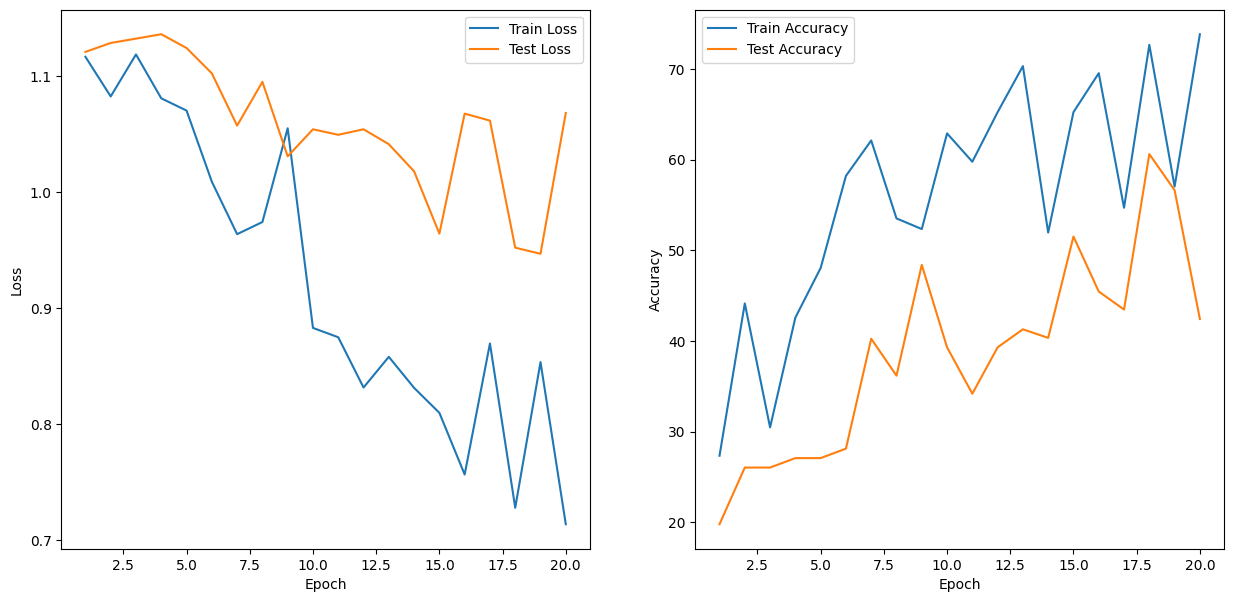

In [137]:
def plot_history(history:dict):
    epochs = range(1, len(history["test_acc"])+1)

    plt.figure(figsize=(15, 7))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["train_loss"], label="Train Loss")
    plt.plot(epochs, history["test_loss"], label="Test Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["train_acc"], label="Train Accuracy")
    plt.plot(epochs, history["test_acc"], label="Test Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.show()


plot_history(history)